# Read in the data

In [225]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [226]:
data['class_size']["GRADE "].value_counts()

12-Sep     10644
MS Core     4762
0K-09       1384
0K          1237
1           1185
2           1167
3           1143
4           1140
5           1086
6            846
7            778
8            735
9             20
Name: GRADE , dtype: int64

In [227]:
data['class_size']['GRADE '] = data['class_size']['GRADE '].replace('12-Sep','09-12')

In [228]:
data['class_size']["GRADE "].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
1           1185
2           1167
3           1143
4           1140
5           1086
6            846
7            778
8            735
9             20
Name: GRADE , dtype: int64

# Read in the surveys

In [229]:
all_survey = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [230]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [231]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [232]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [233]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [234]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [235]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [236]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


# Plotting survey correlations

In [237]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

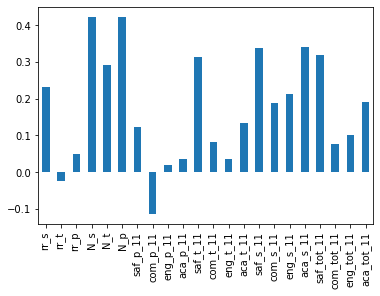

In [238]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

The highest correlatinos are seen between: 
- N_s: Number of student respondents, 
- N_t: Number of teacher respondents, 
- N_p: Number of parent respondents, 
- saf_s_11: Safety and Respect score based on student responses, 
- aca_s_11: Academic expectations score based on parent responses, 
- saf_tot_11: Safety and Respect total score,  
- saf_t_11: Safety and Respect score based on teacher responses.

The number ones are interesting and there are a few ways to think about these. It could be that responsiveness to the survey implies responsibilty, which could be a factor in SAT performance. It could also be that those with a higher score were more willing to share that score. Lastly it could be that a higher number of respondents means a larger school, and larger schools could earn higher SAT scores. 

There are two parts to Safety and Respect scores. The first part, Safety, likely means that students who feel comfortable at school are able to better focus on academic development. Respect could either be interpreted as student's with a better respect for authority which could cause higher scores, or it could imply that the teachers are better and command a higher degree of respect.

Lastly, Academic Expectations from parents seems like a pretty obvious one.

# Investigating Safety Scores

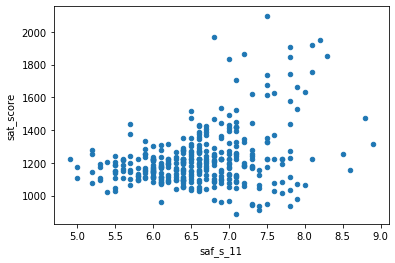

In [239]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

There does seem to be a slight positive trend until a school reaches a saf_s_11 score of ~6.5, after which the positive trend seems to be stronger. No school at 6.5 or below averages an SAT score higher than 1600.

In [240]:
try:
    from inspect import cleandoc as dedent
except ImportError:
    # Deprecated as of version 3.1. Not quite the same
    # as textwrap.dedent.
    from matplotlib.cbook import dedent

C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


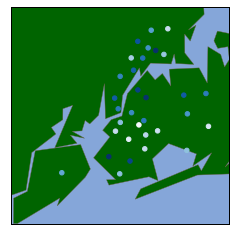

In [241]:
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = r'C:\Users\WWCOLL\AppData\Local\Continuum\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='darkgreen',lake_color='#85A6D9')

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='Blues')
plt.show()

Brooklyn seems to have the lowest, while Mahattan and Queens seem to have higher safety scores.

# Analyzing Racial difference and SAT Scores

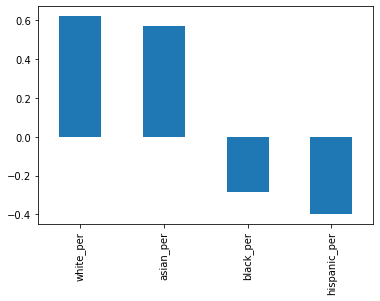

In [242]:
columns = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][columns].plot.bar()

There looks a strong positive correlation between SAT scores and white_per and asian_per, and a small negative correlation between SAT scores and black_per and hispanic_per. This likely has to do with a lack of funding in underpriviledged areas.

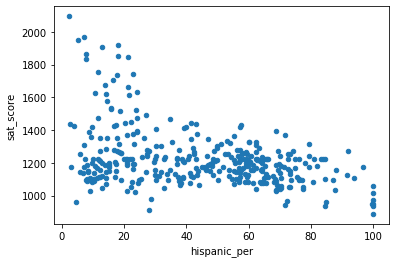

In [243]:
combined.plot.scatter(x='hispanic_per',y='sat_score')

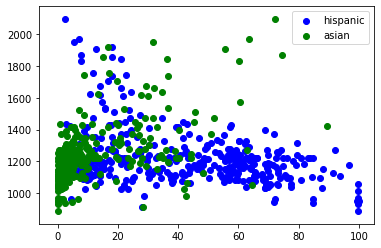

In [244]:
fig, ax = plt.subplots()
ax.scatter(x=combined['hispanic_per'], y=combined['sat_score'],c='blue',label='hispanic')
ax.scatter(x=combined['asian_per'], y=combined['sat_score'],c='green',label='asian')

ax.legend()

In [245]:
hisp_schools = combined[combined['hispanic_per']>=95]
hisp_schools

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135.000000,1.083802e+06,1.010790e+09,Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269.000000,1.063703e+06,1.021550e+09,Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,3760.027701,2.587480e+06,2.515083e+09,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,21502.000000,2.008460e+06,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409.000000,2.015241e+06,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",9.000000,18.000000,56.000000,2.027459e+06,2.038640e+09,West Farms-Bronx River ...,40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",5.000000,37.000000,1180.000000,3.090738e+06,3.040940e+09,park-cemetery-etc-Brooklyn ...,40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,"45 10 94Th Street\nElmhurst, NY 11373\n(40.743...",4.000000,25.000000,463.000000,4.437166e+06,4.016000e+09,Elmhurst ...,40.743303,-73.870575,24


These schools look like they are geared towards recent immigrants and learners where English is not their native language.

In [246]:
low_hisp_schools = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]['SCHOOL NAME']
low_hisp_schools

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools seem to fall in categories such as College Prep, Academically Rigorous, Specialized Admittance. Looks like they have entrance exams which explains how standardized test takers who do well on the entrance exam then do well on their SAT tests.

# Analyzing Gender and SAT Scores

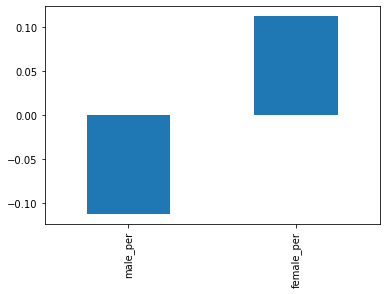

In [247]:
genders = ['male_per','female_per']
combined.corr()['sat_score'][genders].plot.bar()

While both correlations are lower (between -.1 and .1), they do show a slight positive correlation with female_per and a slight negative correlation with male_per. 

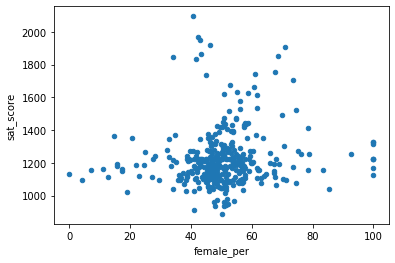

In [248]:
combined.plot.scatter(x='female_per',y='sat_score')

There seems to be a very small correlation for scores below 1500 and the highest scores are at schools where the female_per sits around 40. However, there seem to be a greater number of schools above a 1400 with a female_per above 50. 

In [249]:
female_schools = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME']
female_schools

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Terms appearing to describe this list of schools: liberal arts, selective, music and art, magnet. 

# Analyzing AP Exams and SAT Scores

In [250]:
combined['ap_per'] = (combined['AP Test Takers '])/(combined['total_enrollment'])

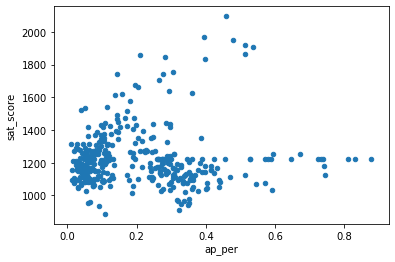

In [251]:
combined.plot.scatter(x='ap_per',y='sat_score')

There seems to a be a small positive correlation up to a certain point (about 0.6). Interesintgly, at that point, it looks like no schools with more than 60% AP Test Takers scored above an average of 1200. 

# Analyzing Class Size and SAT Scores

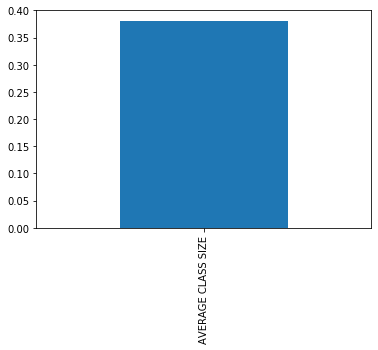

In [252]:
avg_class_size = ['AVERAGE CLASS SIZE']
combined.corr()['sat_score'][avg_class_size].plot.bar()

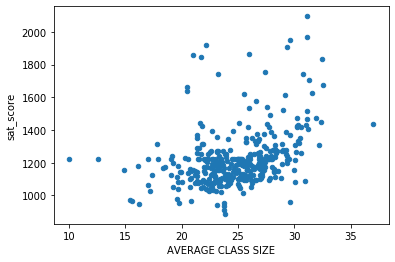

In [253]:
combined.plot.scatter(x='AVERAGE CLASS SIZE',y='sat_score')

There is a moderately strong positive correlatinon between class size and SAT Score. Could be larger schools, smaller schools with fewer but better teachers, could be grades who share many similar classes.

# Analyzing Property Value

Data set from [Zillow](https://www.zillow.com/research/data/). 

In [254]:
prop_value = pd.read_csv(r"C:\Users\WWCOLL\Documents\dataquest\schools/property_value.csv",encoding='windows-1252')
combined = combined.merge(prop_value, how='left',left_on='postcode',right_on='RegionName',suffixes=('','_y'))
combined.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,943230.0,937041.0,937919.0,951897.0,976931.0,1007519.0,1026655.0,1033791.0,1036150.0,1047028.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,943230.0,937041.0,937919.0,951897.0,976931.0,1007519.0,1026655.0,1033791.0,1036150.0,1047028.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,720010.0,741454.0,766547.0,784706.0,794158.0,809053.0,815915.0,820524.0,814990.0,821230.0
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,943230.0,937041.0,937919.0,951897.0,976931.0,1007519.0,1026655.0,1033791.0,1036150.0,1047028.0
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,943230.0,937041.0,937919.0,951897.0,976931.0,1007519.0,1026655.0,1033791.0,1036150.0,1047028.0


This data is from 2012, so we will use the end of that year for property values. 

In [255]:
combined = combined.drop_duplicates(subset=None,keep='first')
avg_combined_zip = combined.groupby('postcode').agg('mean')
avg_combined_zip[['sat_score','2012-12']]

,sat_score,2012-12
postcode,,
10002,1306.090909,766654.0
10003,1232.219403,852659.0
10004,1287.000000,969132.0
10006,1303.500000,773940.0
10009,1149.000000,558461.0
...,...,...
11432,1318.073134,418509.0
11433,1545.719403,326004.0
11434,1152.000000,327595.0


In [256]:
avg_combined_zip['cheap_scores'] = ((avg_combined_zip['sat_score'])/(avg_combined_zip['2012-12']))*1000
avg_combined_zip['cheap_scores']

postcode
10002    1.703625
10003    1.445149
10004    1.327992
10006    1.684239
10009    2.057440
           ...   
11432    3.149450
11433    4.741412
11434    3.516537
11691    3.269050
11694    3.023655
Name: cheap_scores, Length: 116, dtype: float64

SAT point received for every dollar spent in property value. 

I am not sure this is 100% the right or most accurate way to do this since I am averaging scores and property values prior to then calculating a numerical relationship between the two. But I think it will work for illustration and assuming there are enough schools poster per zip. 

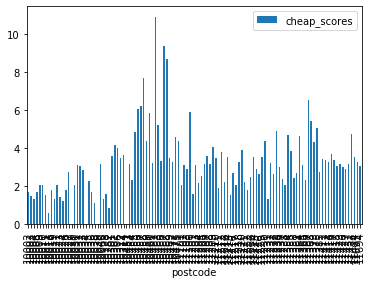

In [257]:
avg_combined_zip.reset_index(inplace=True)
avg_combined_zip.plot.bar(x='postcode',y='cheap_scores')

It looks like 6 could be a good number as a cutoff. 

In [258]:
top_econ_schools = avg_combined_zip[avg_combined_zip['cheap_scores']>6]

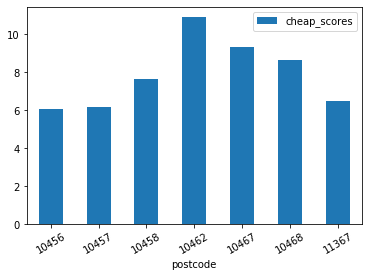

In [259]:
top_econ_schools.plot.bar(x='postcode',y='cheap_scores',rot=30)

In [260]:
zip_10456 = combined[(combined['postcode']==10456)]
zip_10456['borough'].value_counts()

Bronx    10
Name: borough, dtype: int64

In [262]:
zip_10457 = combined[(combined['postcode']==10457)]
zip_10457['borough'].value_counts()

Bronx    11
Name: borough, dtype: int64

In [271]:
zips = combined[combined['postcode'].isin([10456,10457,10458,10462,10467,10468,11367])]
zips['borough'].value_counts()

Bronx     42
Queens     2
Name: borough, dtype: int64

It looks like the best bang for your buck in terms of SAT Scores is to move to the Bronx. 